# DEA Notebook 

![alt text](../dea-gallery-crop.png "DEA")

### [DEA](https://dea.destine.eu/web) is a Content creation service and no-code platform for DestinE storytelling and data visualization

# Query DEA Plot API – Retrieve Plot Data as JSON

This notebook demonstrates how to query the DEA plot API to retrieve JSON-formatted data.
These data responses can be used to customise and visualise plots according to your needs, directly in your own applications or notebooks.

> **_NOTE:_** The returned data includes time series values that are linked to a specific query (e.g. map point or area, variable).

---

## API to JSON – Flow Overview
A JSON response can be obtained by querying the DEA plot API with the appropriate parameters.
This allows flexible retrieval of values for analysis or visualisation purposes.

Here’s the step-by-step workflow: <br>
<br>
📥 Prepare your API query parameters (e.g. location, variable) <br>
└── You can find available options in the API documentation or via the DEA frontend <br>

🌐 Send a request to the DEA Plot API endpoint <br>
└── Either through a direct HTTP request or using Python code (e.g. requests.get) <br>

📊 Receive a JSON response with structured data <br>
└── The response includes metadata (location, plot type) and data values (e.g. list of dates and values) <br>

🖼️ Optionally visualise or export the retrieved data <br>
└── Generate static plots, interactive charts, or even animations <br>

🛠️ Use the data for custom plots or analysis <br>
└── Easily integrate into Matplotlib, Plotly, or other plotting libraries <br>

---

## Notebook Agenda

1. **Load Dependencies**
2. **Define Plot Query Parameters**
3. **Send API Request to DEA Plot Service**
4. **Inspect the JSON Response**
5. **Extract and Visualise the Data**
6. **Customise Your Plot or Export**
7. **Requesting Multiple Variables (Including a Pressure-Level Variable)**

# 1. Load Dependencies

This notebook doesn't require the installation of any prerequisites, only the import of necessary modules.

### Import necesary python library

In [1]:
import os
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint

import base64
from io import BytesIO
from PIL import Image
from IPython.display import Image as IPImage, display

# 2. Define Plot Query Parameters


In this cell, we define the parameters needed to query the DEA Plot API.

- `url`: the API endpoint used to retrieve time series data in JSON format  
- `payload`: the POST request body, which includes:
  - `name`: the name of the variable to query (e.g. `"skt"` for skin temperature from ECMWF open-data)
  - `locationType`: set to `"LONLAT"` to indicate that the location is a point
  - `location`: a dictionary with `latitude` and `longitude` values (in WGS84, EPSG:4326)
  - `plotEnabled`: set to `"true"` to ensure that a plot-ready image is returned together with the JSON response

You can modify the variable name or coordinates to get data for different locations or quantities.

For this example, we retrieve the Skin Temperature in Vienna.

In [2]:
url = "https://dea.destine.eu/py-api/wmsLayers/plot"
payload = {
    "name": ["skt"],
    "locationType": "LONLAT",
    "location": {"longitude": "16.44", "latitude": "48.25"}, # Vienna
    "plotEnabled": True
}
# "location": {"longitude": "-3.68", "latitude": "40.43"} # Madrid

# 3. Send API Request to DEA Plot Service


In this step, we send a `POST` request to the DEA Plot API using the parameters defined above.  
We check that the response status is `200 OK` to ensure the request was successful before extracting the returned JSON data.

In [3]:
response = requests.post(url, json=payload)
data = response.json()

In [4]:
# Check that the response is successful
if response.status_code == 200:
    data = response.json()
    print("✅ API request successful. Data retrieved.")
    print(data.keys())
else:
    print(f"❌ API request failed with status code {response.status_code}")
    print(response.text)

✅ API request successful. Data retrieved.
dict_keys(['data', 'plot_image'])


# 4. Inspect the JSON response

After a successful API request, we can explore the structure of the JSON response.

Here, we print:
- The plot metadata (`plot_vars`), which includes axis labels and title
- The first few timestamps (`times`) available in the series
- The first few corresponding values (`vals`) at the selected location

This quick inspection helps ensure the data was returned correctly and gives us context for processing or visualising it.

Finally, we also display the plot image included in the JSON response and we save it on disk.

### Data inspection

In [5]:
pprint(data["data"][0]["plot_vars"])
pprint(data["data"][0]["times"][:5])  # first 5 time steps
pprint(data["data"][0]["custom_dimension_values"][0]["values"][0]["vals"][:5])  # first 5 values

{'level_unit': None,
 'title': 'Skin temperature',
 'xlabel': 'Time',
 'ylabel': 'skt [K]'}
['2025-06-17T00:00:00',
 '2025-06-17T03:00:00',
 '2025-06-17T06:00:00',
 '2025-06-17T09:00:00',
 '2025-06-17T12:00:00']
[289.42529296875,
 288.5450439453125,
 292.70849609375,
 301.360595703125,
 304.12152099609375]


### Plot preview from response

✅ Image saved as 'plot-api_output/dea_plot.png'


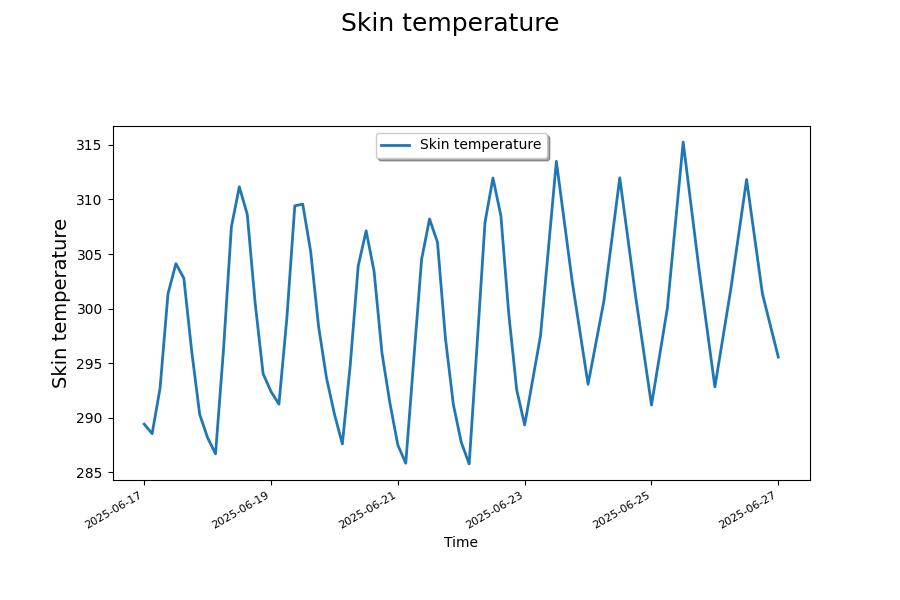

In [6]:
def extract_and_display_plot_image(html_base64_str, output_filename="plot_result.png"):
    """
    Extract the base64 PNG image from an HTML string, save it to disk, and display it.

    Parameters:
    - html_base64_str (str): The HTML string containing the base64 image.
    - output_filename (str): The name of the output image file to save (default: 'plot_result.png').

    Returns:
    - None
    """
    prefix = "data:image/png;base64,"



    try:
        # Locate the beginning of the base64-encoded image
        base64_start = html_base64_str.find(prefix)
        if base64_start == -1:
            raise ValueError("⚠️ Could not find base64 image prefix in the HTML string.")

        # Extract the base64 string
        img_b64 = html_base64_str[base64_start + len(prefix):]
        img_b64 = img_b64.split("'")[0].strip()  # Clean any trailing HTML tags or characters

        # Decode base64 into binary image data
        img_data = base64.b64decode(img_b64)

        # Save the image to disk
        with open(output_filename, "wb") as f:
            f.write(img_data)
        print(f"✅ Image saved as '{output_filename}'")

        # Display the image inside a notebook (optional)
        display(IPImage(filename=output_filename))

    except Exception as e:
        print(f"❌ Error while extracting or saving the image: {e}")

output_dir = "plot-api_output"
os.makedirs(output_dir, exist_ok=True)

filename = "dea_plot.png"
filepath = os.path.join(output_dir, filename)
extract_and_display_plot_image(data["plot_image"], output_filename=filepath)

# 5. Extract and Visualise the data

In this step, we extract the time series from the JSON response and organize it into a pandas DataFrame.
We also retrieve the variable label and axis labels from the metadata, so the plot can be self-explanatory.

In [7]:
times = pd.to_datetime(data["data"][0]["times"])
values = data["data"][0]["custom_dimension_values"][0]["values"][0]["vals"]
label = data["data"][0]["plot_vars"]["title"]
ylabel = data["data"][0]["plot_vars"]["ylabel"]

# Create a DataFrame
df = pd.DataFrame({"Time": times, "Value": values})

### Export as JSON

Once the data is structured, we export it to a JSON file using ISO 8601 timestamps.
This is useful for sharing the result, reusing the time series in external tools, or powering a frontend visualization.

In [8]:
# Select relevant columns for export
export_data = df[["Time", "Value"]].copy()

# Convert datetime to ISO format string
export_data["Time"] = export_data["Time"].dt.strftime('%Y-%m-%dT%H:%M:%S')

# Export to JSON
filename = "skt_timeseries_vienna.json"
filepath = os.path.join(output_dir, filename)
export_data.to_json(filepath, orient="records", indent=2)

print(f"JSON file saved as {filepath}")

JSON file saved as plot-api_output/skt_timeseries_vienna.json


### Visualise the data

Finally, we plot the extracted values using Matplotlib.
The plot includes timestamps on the x-axis and the selected variable on the y-axis, as defined by the API response.

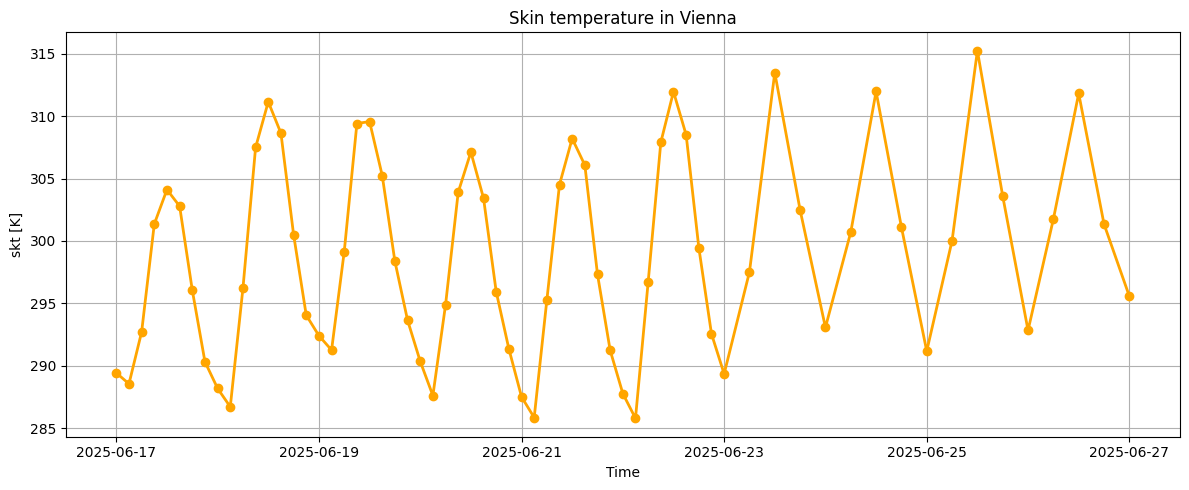

In [9]:
# Plot
plt.figure(figsize=(12, 5))
plt.plot(df["Time"], df["Value"], marker='o', linewidth=2, color='orange')
plt.title(f"{label} in Vienna")
plt.xlabel("Time")
plt.ylabel(ylabel)
plt.grid(True)
plt.tight_layout()

# Save the figure
filename = "skin_temperature_vienna.png"
filepath = os.path.join(output_dir, filename)
plt.savefig(filepath, dpi=150)

plt.show()

# 6. Customise Your Plot

In this step, we convert the original temperature values from Kelvin to Celsius to make them more intuitive for interpretation.

We then show the **Degree Cooling Days (DCD)** using a threshold of **18 °C**, which is commonly used to estimate the need for air conditioning.  
The DCD value represents the extent to which the temperature exceeds this threshold at each time step.

On the plot:
- The blue line shows the temperature in °C.
- The red shaded area highlights where the temperature is above 18 °C.
- A horizontal dashed line marks the 18 °C threshold.

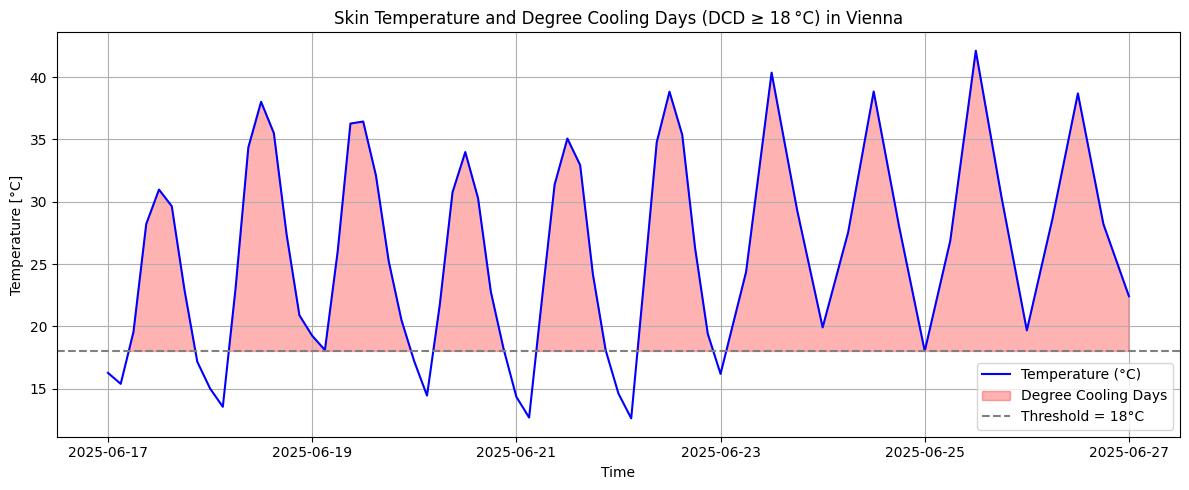

In [10]:
# Convert from Kelvin to Celsius
df["Value_C"] = df["Value"] - 273.15

# Define threshold for cooling (e.g. 18°C)
threshold = 18


# Plot
plt.figure(figsize=(12, 5))
plt.plot(df["Time"], df["Value_C"], label="Temperature (°C)", color="blue")
plt.fill_between(df["Time"], threshold, df["Value_C"], 
                 where=df["Value_C"] > threshold, 
                 interpolate=True, color="red", alpha=0.3, label="Degree Cooling Days")

plt.axhline(threshold, color="gray", linestyle="--", label=f"Threshold = {threshold}°C")
plt.title("Skin Temperature and Degree Cooling Days (DCD ≥ 18 °C) in Vienna")
plt.xlabel("Time")
plt.ylabel("Temperature [°C]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 7. Requesting Multiple Variables (Including a Pressure-Level and a Marine Depth-Level Variable)

In this example, we demonstrate how to request **two different variables** in a single API call.

- The first variable, `t` (air temperature), is defined on **pressure levels**. We specify the pressure level of interest: `100000` Pa, which corresponds approximately to sea-level pressure.
- The second variable is the **CMEMS Sea Water Potential Temperature**, which is defined on **depth levels**. We select the surface level: `0.49` meters below the sea surface.

The selected location is in the **Mediterranean Sea**, where both atmospheric and oceanic parameters are available.  
This kind of multi-variable request is useful for cross-domain analyses (e.g., atmosphere–ocean interactions).

Finally, we will plot the two variables in the commonly available period.

### Load modules

In [11]:
import base64
from io import BytesIO
from PIL import Image
from IPython.display import Image as IPImage, display
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

### a. Define the query and Retrieve data

In [12]:
url = "https://dea.destine.eu/py-api/wmsLayers/plot"
payload = {
    "name": ["thetao_cmems", "t"],
    "custom_dimension_values": [100000],
    "marine_depth": [0.49],
    "locationType": "LONLAT",
    "location": {"longitude": "18.08", "latitude": "35.28"}, # Mediterranean sea spot
    "plotEnabled": True
}

In [13]:
response = requests.post(url, json=payload)
data = response.json()

try:
    data = response.json()
    print(data.keys())
except Exception as e:
    print("❌ Failed to parse JSON:", e)
    print("Content-Type:", response.headers.get("Content-Type"))

dict_keys(['data', 'plot_image'])


### b. Preview data

✅ Image saved as 'plot-api_output/dea_plot_sea_temperature.png'


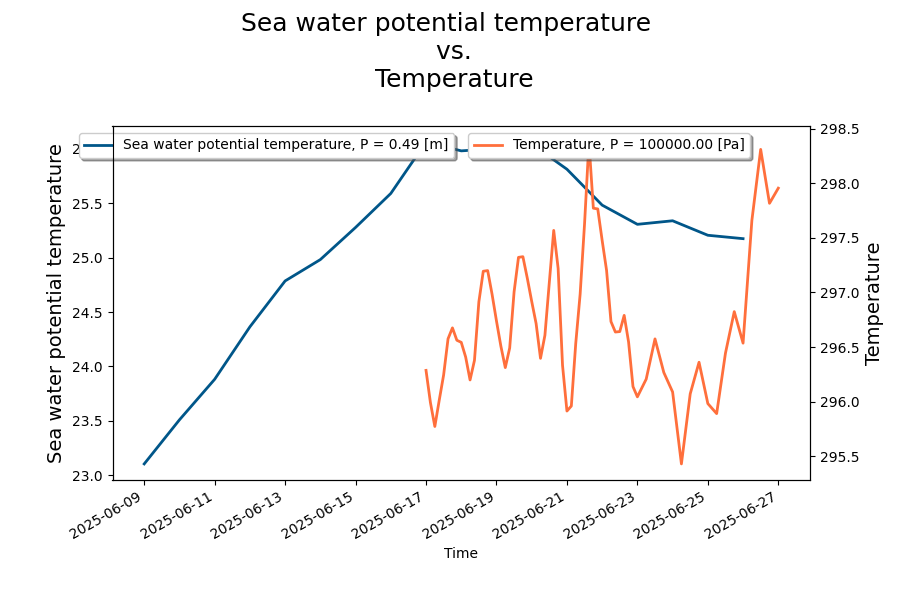

In [14]:
def extract_and_display_plot_image(html_base64_str, output_filename):
    """
    Extract the base64 PNG image from an HTML string, save it to disk, and display it.

    Parameters:
    - html_base64_str (str): The HTML string containing the base64 image.
    - output_filename (str): The name of the output image file to save (default: 'plot_result.png').

    Returns:
    - None
    """
    prefix = "data:image/png;base64,"

    try:
        # Locate the beginning of the base64-encoded image
        base64_start = html_base64_str.find(prefix)
        if base64_start == -1:
            raise ValueError("⚠️ Could not find base64 image prefix in the HTML string.")

        # Extract the base64 string
        img_b64 = html_base64_str[base64_start + len(prefix):]
        img_b64 = img_b64.split("'")[0].strip()  # Clean any trailing HTML tags or characters

        # Decode base64 into binary image data
        img_data = base64.b64decode(img_b64)

        # Save the image to disk
        with open(output_filename, "wb") as f:
            f.write(img_data)
        print(f"✅ Image saved as '{output_filename}'")

        # Display the image inside a notebook (optional)
        display(IPImage(filename=output_filename))

    except Exception as e:
        print(f"❌ Error while extracting or saving the image: {e}")

filename = "dea_plot_sea_temperature.png"
filepath = os.path.join(output_dir, filename)
extract_and_display_plot_image(data["plot_image"], output_filename=filepath)

### c. Save the data for both variables on file

In [15]:
# Save raw response as-is
filename = "mediterranean_raw_response.json"
filepath = os.path.join(output_dir, filename)
with open(filepath, "w") as f:
    json.dump(data['data'], f, indent=2)

### d. Plot the data in the common period


In this step, we visualise the two time series—sea surface temperature and air temperature—only over their common time range.
Instead of hardcoding specific dates, we automatically detect the start and end of the available period for the air temperature variable (usually the one with fewer time points). We then filter both datasets to keep only the overlapping timestamps.

This ensures a fair visual comparison between the two variables, even if they have different temporal resolutions.

The air temperature values are also converted from Kelvin to Celsius, so they can be plotted on the same axis as the sea temperature.

Finally, we generate a line plot showing both curves with distinct markers and colors, and format the time axis to clearly show the temporal evolution.

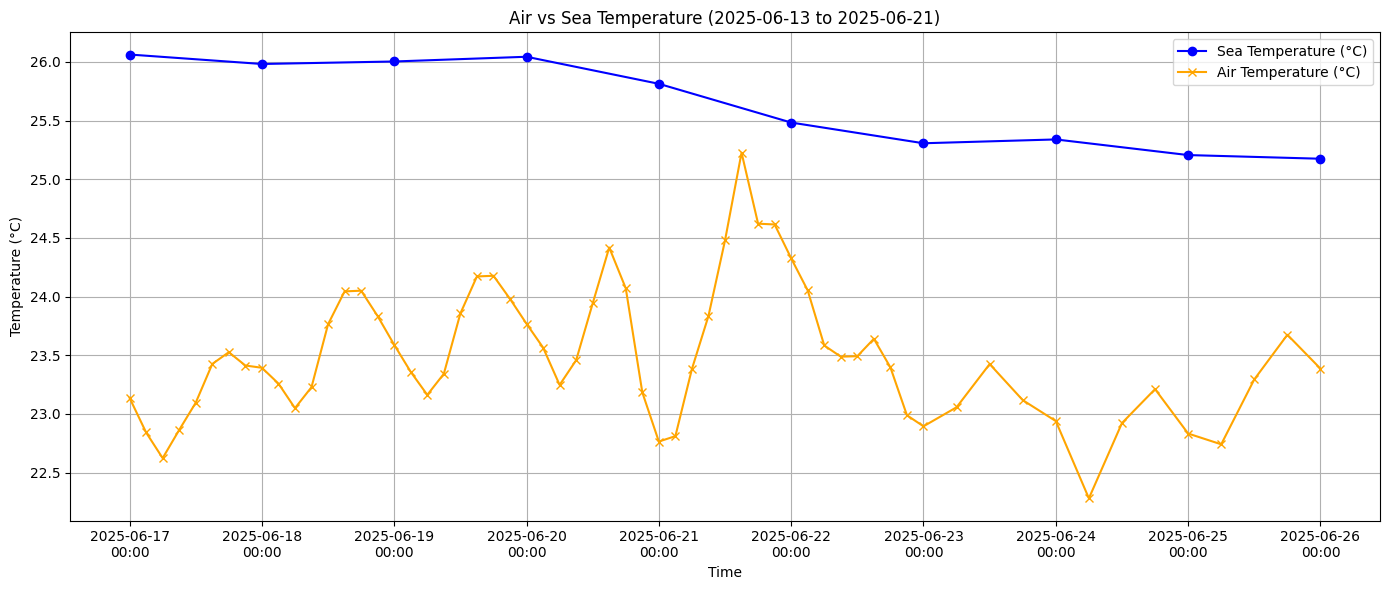

In [16]:
# Extract both variables
var1 = data["data"][0]  # thetao_cmems
var2 = data["data"][1]  # t

# Extract times and values
times1 = pd.to_datetime(var1["times"])
values1 = var1["custom_dimension_values"][0]["values"][0]["vals"]
df1 = pd.DataFrame({"Time": times1, "SeaTemp_C": values1})

times2 = pd.to_datetime(var2["times"])
values2 = var2["custom_dimension_values"][0]["values"][0]["vals"]
df2 = pd.DataFrame({"Time": times2, "AirTemp_C": [v - 273.15 for v in values2]})

# Filter common time window
start_date = df2["Time"].min()
end_date = df1["Time"].max()
df1 = df1[(df1["Time"] >= start_date) & (df1["Time"] <= end_date)]
df2 = df2[(df2["Time"] >= start_date) & (df2["Time"] <= end_date)]

# Plot
plt.figure(figsize=(14, 6))
plt.plot(df1["Time"], df1["SeaTemp_C"], label="Sea Temperature (°C)", marker='o', color='blue')
plt.plot(df2["Time"], df2["AirTemp_C"], label="Air Temperature (°C)", marker='x', color='orange')

plt.title("Air vs Sea Temperature (2025-06-13 to 2025-06-21)")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.legend()

# Improve time axis formatting
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d\n%H:%M"))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.tight_layout()

filename = "air_sea_temperature_comparison.png"
filepath = os.path.join(output_dir, filename)
plt.savefig(filepath, dpi=150)
plt.show()